In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable, Iterable

In [2]:
data = np.loadtxt('../support/zipcombo.dat')
# data = np.loadtxt('../support/dtrain123.dat')

In [3]:
data.shape

(9298, 257)

In [4]:
def split_80_20(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits 80% train 20% test

    :param data: sequence.
    :return: train_data, test_data: np.ndarray, np.ndarray
    """

    n = data.shape[0]
    train_size = int(n*0.8)
    return data[:train_size], data[train_size:]

In [5]:
def split_X_y(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits the data into datapoints and labels, X_train matrix and y_train;
    :param data: np.ndarray
    :return: X_train, y_train: np.ndarray, np.ndarray
    """

    return data[:, 1:], data[:, 0]

In [6]:
def shuffle_split(data):
    # np.random.seed(seed)
    shuffled = np.random.permutation(data)
    data_train, data_test = split_80_20(shuffled)
    X_train, y_train = split_X_y(data_train)
    X_test, y_test = split_X_y(data_test)

    assert X_train.shape[0] == y_train.size
    assert X_test.shape[0] == y_test.size

    print("Train data set size = %d" % X_train.shape[0])
    print("Test data set size = %d" % X_test.shape[0])

    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = shuffle_split(data)

Train data set size = 7438
Test data set size = 1860


In [8]:
class KPOneVsOneClassifier:
    def __init__(self, n_classes, d):
        if n_classes <= 1:
            raise Exception("Number of classes 'n_classes' must be greater or equal to 2")
        self.n_classes = n_classes
        self.n_classifiers = n_classes * (n_classes - 1) // 2
        self.d = d
        self.X_train = None
        self.Alpha = None
        self.P = None
        self.K = None

    def _get_penalization_matrix(self, n_classes: int) -> np.ndarray:
        n_classifiers = int(n_classes * (n_classes - 1) / 2)
        P = np.zeros((n_classes, n_classifiers))
        i_start, i_curr = 0, 1
        for j in range(n_classifiers):
            P[i_start, j] = 1
            P[i_curr, j] = -1
            if i_curr == n_classes - 1:
                i_start += 1
                i_curr = i_start + 1
            else:
                i_curr += 1
        return P

    def _get_kernel_matrix(self, X_train: np.ndarray) -> np.ndarray:
        return np.power(X_train @ X_train.T, self.d)

    def sign(self, x: np.ndarray) -> np.ndarray:
        return np.where(x <= 0, -1, 1)

    def fit(self, X_train, y_train, n_epochs) -> None:
        if self.P is None:
            self.P = self._get_penalization_matrix(self.n_classes)

        self.K = self._get_kernel_matrix(X_train)
        self.Alpha = np.zeros((self.n_classifiers, X_train.shape[0]))
        self.X_train = X_train

        for epoch in range(n_epochs):
            # for each point, calculate confidence and make predictions
            for t in range(0, self.X_train.shape[0]):
                # Penalize classifiers that are responsible for predicting y_train[t]
                y_actual = int(y_train[t])
                y_preds = self.sign(self.Alpha @ self.K[t])
                #                       0   if x1 < 0
                # heaviside(x1, x2) =  x2   if x1 == 0
                #                       1   if x1 > 0

                # -1 on mistake, 1 correct, 0 on irrelevant perceptron
                mistake_markers = (y_preds * self.P[y_actual, :])
                self.Alpha[:, t] -= np.heaviside(-mistake_markers, 1) * y_preds

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        # Select majority vote, to break even use random selection
        K_test = np.power(self.X_train @ X_test.T, self.d)
        # Get votes form all classifiers into a vector
        y_votes = np.sign(self.Alpha @ K_test)
        # Sum votes by multiplying penalization matrix with votes vector
        # this is the sum of votes and counter-votes (negative weight) for each digit
        votes_sum = self.P @ y_votes
        return np.argmax(votes_sum, axis=0)

In [9]:
def get_error_percentage(y, y_preds):
    error = 100 * get_num_mistakes(actual=y, predicted=y_preds) / y.size
    # print("in-sample = % " + str(error))
    return error

def get_num_mistakes(actual: np.ndarray, predicted: np.ndarray) -> int:
    # or calculating by checking which alpha values are different than 0? alpha is 0 when the prediction matches
    diffs = actual - predicted
    n_mistakes = 0
    for diff in diffs:
        if diff != 0:
            n_mistakes += 1
    return n_mistakes

# *_Part 1_*

### 1. *Basic results for OVO*
- for $d=1, ... ,7$ perform 20 runs
- split $zipcombo$ 80-20
- report MSE and STD
- yield a 2x7 table that has on each cell $mean+-std$


### We consider the learnings from the OVA algorithm, leaving n_epoch = 7


In [10]:
import time

means_train = []
means_test = []
stds_train = []
stds_test = []

start=time.time()
for d in range(1, 8):
    train_errors = []
    test_errors = []
    for run in range(20):
        X_train, y_train, X_test, y_test = shuffle_split(data)

        kpova = KPOneVsOneClassifier(n_classes=10, d=d)

        #train
        kpova.fit(X_train, y_train, n_epochs=7)
        y_insample = kpova.predict(X_train)
        #test
        y_outsample = kpova.predict(X_test)

        print('\nd=' + str(d) + ' on run ' + str(run))
        train_errors.append(get_error_percentage(y_train, y_insample))
        test_errors.append(get_error_percentage(y_test, y_outsample))
    means_train.append(np.mean(train_errors))
    means_test.append(np.mean(test_errors))
    stds_train.append(np.std(train_errors))
    stds_test.append(np.std(test_errors))
end = time.time()

print('took {t}'.format(t=end-start))

Train data set size = 7438
Test data set size = 1860

d=1 on run 0
Train data set size = 7438
Test data set size = 1860

d=1 on run 1
Train data set size = 7438
Test data set size = 1860

d=1 on run 2
Train data set size = 7438
Test data set size = 1860

d=1 on run 3
Train data set size = 7438
Test data set size = 1860

d=1 on run 4
Train data set size = 7438
Test data set size = 1860

d=1 on run 5
Train data set size = 7438
Test data set size = 1860

d=1 on run 6
Train data set size = 7438
Test data set size = 1860

d=1 on run 7
Train data set size = 7438
Test data set size = 1860

d=1 on run 8
Train data set size = 7438
Test data set size = 1860

d=1 on run 9
Train data set size = 7438
Test data set size = 1860

d=1 on run 10
Train data set size = 7438
Test data set size = 1860

d=1 on run 11
Train data set size = 7438
Test data set size = 1860

d=1 on run 12
Train data set size = 7438
Test data set size = 1860

d=1 on run 13
Train data set size = 7438
Test data set size = 1860

d=1 

In [24]:
import pandas as pd

table_1a = pd.DataFrame({
    'mean train': [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(means_train, stds_train)],
    'mean test': [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(means_test, stds_test)],
})

display(table_1a)
table_1a.to_csv('results_ovo/table_1a.csv')
table_1a.style.to_latex('results_ovo/table_1a.tex')

,mean train,mean test
0,44.654±3.657,45.806±3.806
1,6.808±1.532,10.935±1.458
2,2.154±0.506,5.960±0.710
3,1.071±0.194,4.858±0.479
4,0.574±0.110,4.202±0.515
5,0.536±0.093,4.073±0.418
6,0.475±0.093,3.933±0.547


### 2. _Cross validation for OVO_

- we cross validate on range(4, 10) since we observed in the first experiment that the errors are still quite high until d=4


In [15]:
def cross_validation(X, y, n_folds):
    fold_size = X.shape[0] // n_folds

    split_idxs = [i * fold_size - 1 for i in range(1, 5)]
    X_folds_list = np.split(X, indices_or_sections=split_idxs)
    y_folds_list = np.split(y, indices_or_sections=split_idxs)
    assert len(X_folds_list) == len(y_folds_list) == n_folds

    errors_d = []
    ### BE CAREFUL AT THE OFFSET
    for d in range(4, 11):
        local_errors = []
        for i in range(n_folds):
            # Create a training and test folds from given data
            X_train_fold = np.vstack(([X_folds_list[k] for k in range(0, n_folds) if k != i]))
            y_train_fold = np.concatenate([y_folds_list[k] for k in range(0, n_folds) if k != i], axis=0)
            X_validation_fold = X_folds_list[i]
            y_validation_fold = y_folds_list[i]

            kp = KPOneVsOneClassifier(n_classes=10, d=d)
            kp.fit(X_train_fold, y_train_fold, n_epochs=7)
            y_preds = kp.predict(X_validation_fold)

            # find the hardest points to predict
            train_diffs = y_validation_fold - y_preds
            for pos in np.where(train_diffs!=0):
                mistakes[pos] += 1

            local_errors.append(get_error_percentage(y_validation_fold, y_preds))
        errors_d.append(local_errors)

    # +4 because we consider only ds starting from 4
    return np.argmax(np.mean(errors_d, axis=1)) + 4

In [13]:
# calculate the number of instances of each digit in the dataset
# since we just reshuffle, the number holds for cross validation as well
instances = np.array(np.zeros(10, dtype='int'))

for y in y_train:
    instances[int(y)]+=1
for y in y_test:
    instances[int(y)]+=1

instances

array([1553, 1269,  929,  824,  852,  716,  834,  792,  708,  821])

In [16]:
best_ds = []
test_errors = []
confusion_matrix = np.array(np.zeros((10, 10, 20)))
mistakes = np.array(np.zeros(data.shape[0]))

for run in range(20):
    print('\nRUN = '+str(run))
    shuffled = np.random.permutation(data)
    train_data, test_data = split_80_20(shuffled)
    X_train, y_train = split_X_y(train_data)
    X_test, y_test = split_X_y(test_data)

    best_d = cross_validation(X_train, y_train, 5)

    print('\n      Best D = ' + str(best_d))
    kpova = KPOneVsOneClassifier(n_classes=10, d=best_d)
    kpova.fit(X_train, y_train, n_epochs=7)
    y_outsample = kpova.predict(X_test)
    test_error = get_error_percentage(y_test, y_outsample)

    print('\n      Retrain DONE')

    # find the hardest points to predict
    train_diffs = y_test - y_outsample
    for pos in np.where(train_diffs!=0):
        mistakes[pos] += 1

    # get errors per digit for CONFUSION MATRIX
    local_conf = np.array(np.zeros((10, 10)))
    for (truth, pred) in zip(y_test, y_outsample):
        if truth!=pred:
            local_conf[int(truth), int(pred)] += 1

    print('\n      Confusion matrix DONE')
    # in local_conf divide each row by instances[row]
    # stack the entire matrix in the third dimension
    confusion_matrix[:, :, run] = local_conf / instances[:, None]

    best_ds.append(best_d)
    test_errors.append(test_error)


RUN = 0

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 1

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 2

      Best D = 5

      Retrain DONE

      Confusion matrix DONE

RUN = 3

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 4

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 5

      Best D = 10

      Retrain DONE

      Confusion matrix DONE

RUN = 6

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 7

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 8

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 9

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 10

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 11

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 12

      Best D = 4

      Retrain DONE

      Confusion matrix DONE

RUN = 1

In [18]:
np.savetxt('results_ovo/mistakes_ovo.npy', mistakes)

# point 2 - CROSS VALIDATION
ds_errors = pd.DataFrame({
    'best_ds' : best_ds,
    'test_errors' : test_errors,
})

print(str(f'{np.mean(best_ds):.3f}') + u"\u00B1" + str(f'{np.std(best_ds):.3f}'))
print(str(f'{np.mean(test_errors):.3f}') + u"\u00B1" + str(f'{np.std(test_errors):.3f}'))

ds_errors.to_csv('results_ovo/best_d_errors.csv')
ds_errors.style.to_latex('results_ovo/best_d_errors.tex')

4.650±1.797
4.858±0.541


In [19]:
# point 3 - CONFUSION MATRIX

mean_confusion = confusion_matrix.mean(axis=2)
std_confusion = confusion_matrix.std(axis=2)
mean_std = np.array(np.zeros((10, 10))).astype('U')

for i in range(mean_confusion.shape[0]):
    mean_std[i] = [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(mean_confusion[i], std_confusion[i])]

# save means and stddev separately
pd.DataFrame(mean_confusion).to_csv('results_ovo/means_confusion.csv')
pd.DataFrame(std_confusion).to_csv('results_ovo/stddev_confusion.csv')

# save and print the combined matrices
mean_std_df = pd.DataFrame(mean_std)
mean_std_df.to_csv('results_ovo/confusion_matrix.csv')
mean_std_df.style.to_latex('results_ovo/confusion_matrix.tex')

mean_std_df

,0,1,2,3,4,5,6,7,8,9
0,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000
1,0.001±0.005,0.000±0.000,0.000±0.001,0.000±0.000,0.001±0.003,0.000±0.001,0.000±0.000,0.000±0.000,0.000±0.000,0.000±0.000
2,0.002±0.002,0.001±0.001,0.000±0.000,0.001±0.001,0.001±0.001,0.000±0.001,0.000±0.001,0.001±0.001,0.000±0.001,0.000±0.001
3,0.001±0.001,0.000±0.001,0.002±0.002,0.000±0.000,0.001±0.001,0.003±0.002,0.000±0.000,0.001±0.001,0.001±0.001,0.001±0.001
4,0.001±0.002,0.002±0.002,0.003±0.001,0.001±0.001,0.000±0.000,0.001±0.001,0.001±0.001,0.000±0.001,0.000±0.000,0.002±0.003
5,0.003±0.002,0.000±0.001,0.002±0.002,0.004±0.003,0.003±0.002,0.000±0.000,0.001±0.001,0.000±0.001,0.001±0.001,0.001±0.002
6,0.003±0.002,0.001±0.001,0.001±0.001,0.001±0.001,0.002±0.002,0.001±0.002,0.000±0.000,0.000±0.000,0.001±0.001,0.000±0.001
7,0.001±0.001,0.001±0.002,0.001±0.001,0.001±0.001,0.003±0.002,0.001±0.002,0.001±0.003,0.000±0.000,0.001±0.001,0.002±0.002
8,0.005±0.002,0.002±0.001,0.002±0.002,0.004±0.003,0.002±0.002,0.003±0.002,0.002±0.002,0.001±0.001,0.000±0.000,0.001±0.001
9,0.001±0.001,0.002±0.002,0.001±0.001,0.001±0.001,0.004±0.003,0.001±0.002,0.001±0.002,0.003±0.002,0.001±0.001,0.000±0.000


<AxesSubplot: >

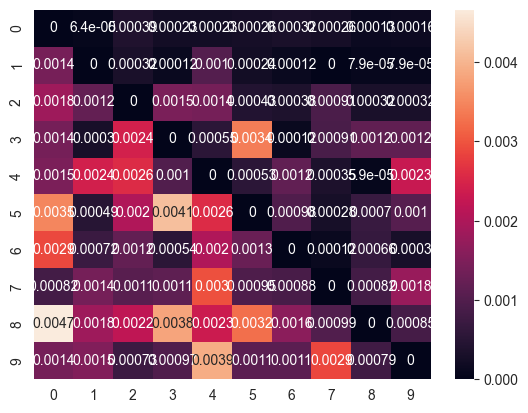

In [20]:
import seaborn as sns
# create confusion matrix heatmap to show more intuitive results
sns.heatmap(mean_confusion, annot=True)


<AxesSubplot: >

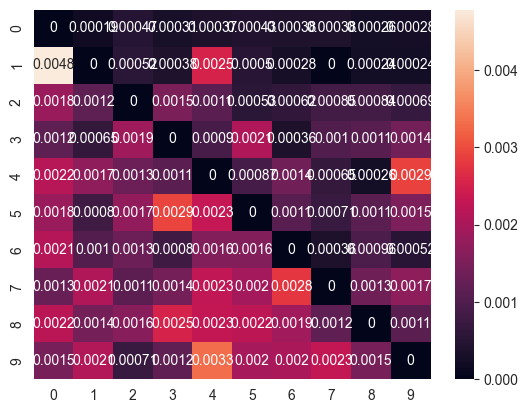

In [21]:
sns.heatmap(std_confusion, annot=True)

#### 4. _TOP 5 hardest points to predict_

- We use 20 runs of cross validation and average the results to yield the best $d$ in general, for any configuration of this dataset
- Per run, cross_validation helps us find the best $d$ for that exact dataset configuration(shuffle).
- Therefore, it is sound to amend the same algorithm to find the Top 5, even if we consider that $d$ might vary between the 20 runs.

- PRO: what is the probability that in 20 runs, by counting the mistakes on 20% of the dataset, we actually take into account all points in a dataset?
- CONTRA: you predict on the dataset it was also trained on, in the same order
- The best way to determine this would be Leave One Out with the best d, training on all datasets points but 1(or n), and test on it. But the time did not permit for something like this


In [22]:
def display_digit(grayscale):
    plt.imshow(np.reshape(grayscale, (16, 16)), cmap='gray')
    plt.show()

9.0


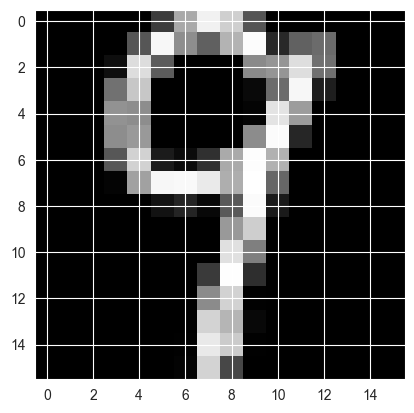



3.0


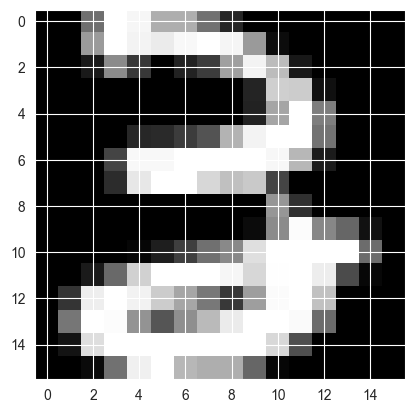



4.0


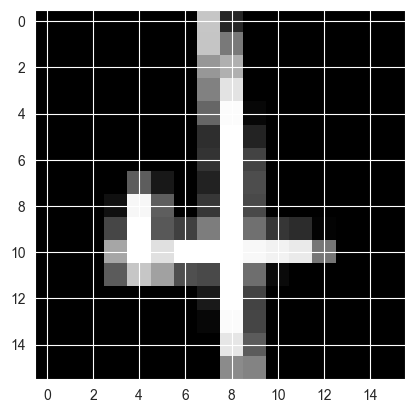



4.0


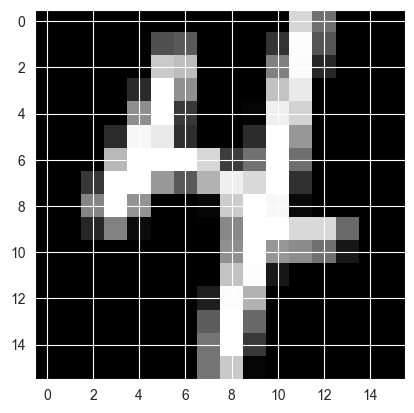



2.0


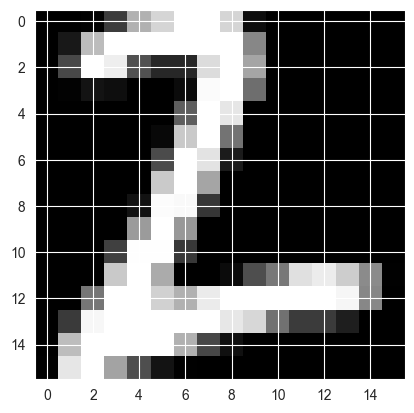

In [23]:
hard_points_labels = []
hard_points = []

for digit_index in np.argsort(mistakes)[-5:]:
    label = data[digit_index][0]
    point = data[digit_index][1:]
    print(label)
    display_digit(point)
    print('\n')